<a href="https://colab.research.google.com/github/jillianhaig/Project3_DS4002/blob/main/SCRIPTS/3_Project3Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This code runs our model, first connecting to google drive and importing the
# images into GitHub through Google Drive, since GitHub is not large enough to store the images

In [1]:
from google.colab import drive
from google.colab import files
import zipfile
import os
import pandas as pd

# Mount Google Drive to access the dataset
drive.mount('/content/drive')

# Path to the zip file on Google Drive (need to change for your path)
zip_file_path = '/content/drive/My Drive/vehicleimages.zip'

# Directory where you want to extract the files
extract_to_path = '/content/vehicleimages'

# Unzip the dataset
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

print(f"Dataset unzipped to: {extract_to_path}")

image_paths = []
labels = []

vehicle_types = os.listdir(extract_to_path)

# For each subdirectory, get image paths
for vehicle_type in vehicle_types:
    vehicle_folder = os.path.join(extract_to_path, vehicle_type)

    if os.path.isdir(vehicle_folder):
        for img_file in os.listdir(vehicle_folder):
            if img_file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                image_path = os.path.join(vehicle_folder, img_file)
                image_paths.append(image_path)
                labels.append(vehicle_type)

df = pd.DataFrame({'image_path': image_paths, 'label': labels})

Mounted at /content/drive
Dataset unzipped to: /content/vehicleimages


# CNN Model Construction and Compiling

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Assuming `df` is a pandas DataFrame with file paths to images and their corresponding labels
# df should contain a column 'file_path' with paths to images and a column 'label' with corresponding class labels

# Load the pre-trained ResNet50 model
resnet50_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of ResNet50 to prevent updating during initial training
resnet50_base.trainable = False

# Define the custom classification head
model = models.Sequential([
    resnet50_base,  # Pre-trained ResNet50 model
    layers.GlobalAveragePooling2D(),  # Global Average Pooling layer
    layers.Dense(512, activation='relu'),  # Fully connected layer
    layers.Dropout(0.5),  # Dropout layer to prevent overfitting
    layers.Dense(5, activation='softmax')  # Output layer with 5 units for 5 vehicle classes
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display model architecture
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,639,365 (93.99 MB)

 Trainable params: 1,051,653 (4.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

# Initial Model Training

In [3]:
from tensorflow.keras.callbacks import EarlyStopping

# Preprocessing the data (resizing and normalizing images)
image_size = (224, 224)

# Create an ImageDataGenerator to load images with augmentation for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

# Example of file paths and labels:
# df['image_path'] - list of paths to images
# df['label'] - list of integer class labels (0 to 4 for 5 vehicle types)

# Train-test split (90-10 split)
train_paths, val_paths, train_labels, val_labels = train_test_split(df['image_path'], df['label'], test_size=0.1, stratify=df['label'])

# Create ImageDataGenerators for training and validation
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df.loc[train_paths.index],
    directory='/content',
    x_col='image_path',
    y_col='label',
    target_size=image_size,
    batch_size=32,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=df.loc[val_paths.index],
    directory='/content',
    x_col='image_path',
    y_col='label',
    target_size=image_size,
    batch_size=32,
    class_mode='categorical'
)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=5,  # Or any number you prefer, but EarlyStopping will stop early if necessary
    validation_data=validation_generator,
    verbose=1,
    callbacks=[early_stopping]  # Add EarlyStopping
)

Found 3920 validated image filenames belonging to 5 classes.
Found 436 validated image filenames belonging to 5 classes.
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


123/123 ━━━━━━━━━━━━━━━━━━━━ 85s 563ms/step - accuracy: 0.2767 - loss: 1.7182 - val_accuracy: 0.3028 - val_loss: 1.5245
Epoch 2/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 56s 432ms/step - accuracy: 0.3082 - loss: 1.5385 - val_accuracy: 0.3280 - val_loss: 1.5004
Epoch 3/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 84s 447ms/step - accuracy: 0.3231 - loss: 1.5152 - val_accuracy: 0.3303 - val_loss: 1.4985
Epoch 4/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 55s 425ms/step - accuracy: 0.3459 - loss: 1.4948 - val_accuracy: 0.2982 - val_loss: 1.5320
Epoch 5/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 81s 421ms/step - accuracy: 0.3340 - loss: 1.5068 - val_accuracy: 0.3349 - val_loss: 1.4739


# Fine Tuning the Model

In [4]:
# Unfreeze the top layers of ResNet50 for fine-tuning
for layer in resnet50_base.layers[-10:]:  # Unfreeze the last 10 layers of ResNet50
    layer.trainable = True

# Recompile the model after unfreezing some layers
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune the model
history_finetune = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    verbose=1,
    callbacks=[early_stopping]  # Add EarlyStopping
)

Epoch 1/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 80s 512ms/step - accuracy: 0.3225 - loss: 2.1699 - val_accuracy: 0.3211 - val_loss: 1.4880
Epoch 2/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 56s 428ms/step - accuracy: 0.4032 - loss: 1.4091 - val_accuracy: 0.3326 - val_loss: 1.5295
Epoch 3/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 59s 440ms/step - accuracy: 0.4467 - loss: 1.3646 - val_accuracy: 0.4472 - val_loss: 1.3352
Epoch 4/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 56s 421ms/step - accuracy: 0.4274 - loss: 1.3334 - val_accuracy: 0.4679 - val_loss: 1.2335
Epoch 5/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 82s 422ms/step - accuracy: 0.4456 - loss: 1.3069 - val_accuracy: 0.4931 - val_loss: 1.1816


# Evaluation and Conclusion

In [18]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Assuming you already have 'df', 'train_datagen', 'validation_datagen', 'model', 'early_stopping', and 'image_size'

# Initialize the LabelEncoder
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

# List of the labels you want to calculate average accuracy for
labels = ["pickup", "suv", "other", "hatchback", "sedan"]

# K-fold cross-validation
kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
accuracies = []
f1_scores = []
label_accuracies = {label: [] for label in labels}  # To store per-label accuracy for each fold

for train_idx, test_idx in kfold.split(df['image_path'], df['label_encoded']):
    # Split the data into training and testing
    train_labels, test_labels = df['label_encoded'].iloc[train_idx], df['label_encoded'].iloc[test_idx]

    # Prepare generators for training and testing
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=df.loc[train_idx],
        directory='/content',
        x_col='image_path',
        y_col='label',  # Use 'label' column which has the original string labels
        target_size=image_size,
        batch_size=32,
        class_mode='categorical'
    )

    test_generator = validation_datagen.flow_from_dataframe(
        dataframe=df.loc[test_idx],
        directory='/content',
        x_col='image_path',
        y_col='label',  # Use 'label' column which has the original string labels
        target_size=image_size,
        batch_size=32,
        class_mode='categorical'
    )

    # Train the model on the current fold
    model.fit(train_generator, epochs=2, validation_data=test_generator, callbacks=[early_stopping])

    # Evaluate the model on the test set
    y_pred = model.predict(test_generator, verbose=1)
    y_true = test_labels  # We use the encoded labels directly for evaluation

    # Calculate overall accuracy and F1 score
    acc = accuracy_score(y_true, y_pred.argmax(axis=1))
    f1 = f1_score(y_true, y_pred.argmax(axis=1), average='weighted')

    accuracies.append(acc)
    f1_scores.append(f1)

    # calculate per-label accuracy for this fold
    for i, label in enumerate(labels):
        label_idx = label_encoder.transform([label])[0]
        label_mask = (y_true == label_idx)
        if np.sum(label_mask) > 0:
            # calculate accuracy for the current label
            label_acc = accuracy_score(y_true[label_mask], y_pred[label_mask].argmax(axis=1))
            label_accuracies[label].append(label_acc)

# average accuracy for each label across all folds
average_label_accuracies = {label: np.mean(accs) if accs else 0 for label, accs in label_accuracies.items()}

Found 2178 validated image filenames belonging to 5 classes.
Found 2178 validated image filenames belonging to 5 classes.
Epoch 1/2


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


69/69 ━━━━━━━━━━━━━━━━━━━━ 41s 553ms/step - accuracy: 0.6428 - loss: 0.9296 - val_accuracy: 0.7502 - val_loss: 0.7045
Epoch 2/2
69/69 ━━━━━━━━━━━━━━━━━━━━ 56s 782ms/step - accuracy: 0.6638 - loss: 0.8958 - val_accuracy: 0.6951 - val_loss: 0.7730
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step
Found 2178 validated image filenames belonging to 5 classes.
Found 2178 validated image filenames belonging to 5 classes.
Epoch 1/2


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


69/69 ━━━━━━━━━━━━━━━━━━━━ 37s 503ms/step - accuracy: 0.6360 - loss: 0.9334 - val_accuracy: 0.7034 - val_loss: 0.7659
Epoch 2/2
69/69 ━━━━━━━━━━━━━━━━━━━━ 40s 550ms/step - accuracy: 0.6360 - loss: 0.9417 - val_accuracy: 0.7764 - val_loss: 0.6350
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step
Average Accuracy for each label: {'pickup': 0.3612903225806452, 'suv': 0.13676470588235293, 'other': 0.13666666666666666, 'hatchback': 0.10066006600660066, 'sedan': 0.27723577235772356}


# Results and Visualization

In [19]:
# print out the results
print("Average accuracy for each label:")
for label, avg_acc in average_label_accuracies.items():
    print(f"{label}: {avg_acc:.4f}")

avg_accuracy = np.mean(accuracies)
avg_f1_score = np.mean(f1_scores)

print(f"\nAverage overall accuracy: {avg_accuracy:.4f}")
print(f"Average weighted F1 score: {avg_f1_score:.4f}")

Average accuracy for each label:
pickup: 0.3613
suv: 0.1368
other: 0.1367
hatchback: 0.1007
sedan: 0.2772

Average overall accuracy: 0.2353
Average weighted F1 score: 0.2275


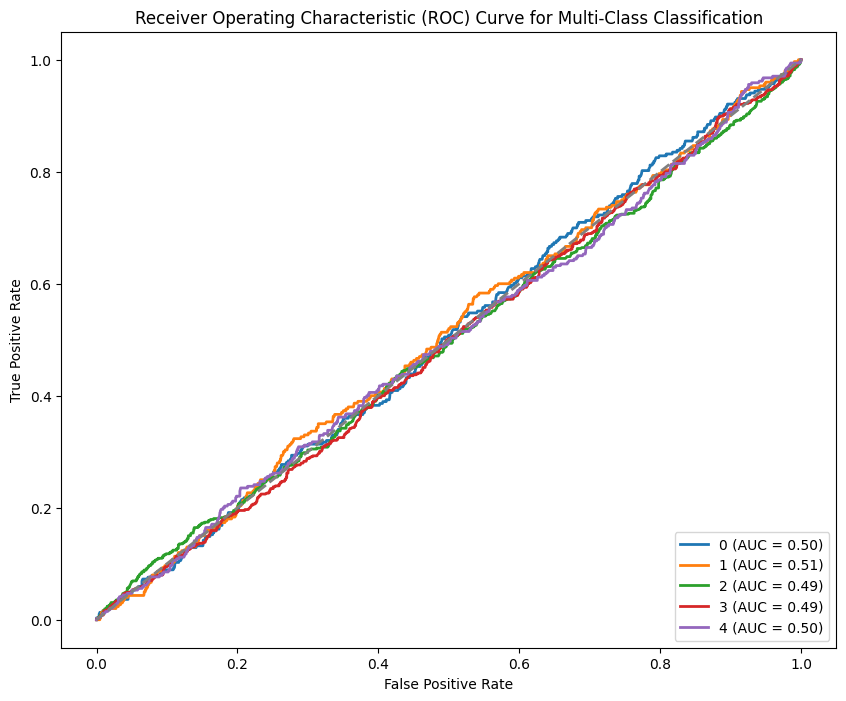

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score

# Assuming y_true and y_pred are already defined, and they are the true labels and predicted probabilities

y_true_all = []
y_probs_all = []

# Store true labels and predicted probabilities for ROC curve
y_true_all.append(y_true)
y_probs_all.append(y_pred)

# Convert lists of true labels and predicted probabilities to arrays
y_true_all = np.concatenate(y_true_all, axis=0)
y_probs_all = np.concatenate(y_probs_all, axis=0)

# Binarize the true labels (multi-class to binary for each class)
lb = LabelBinarizer()
y_true_bin = lb.fit_transform(y_true_all)

# Plot ROC curve for each class
n_classes = y_true_bin.shape[1]
plt.figure(figsize=(10, 8))

# Loop over each class to plot its ROC curve
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs_all[:, i])
    roc_auc = auc(fpr, tpr)
    # Use lb.classes_ to get the actual class name for the index 'i'
    class_name = lb.classes_[i]
    # Plot the ROC curve for the current class with its AUC score
    plt.plot(fpr, tpr, lw=2, label=f'{class_name} (AUC = {roc_auc:.2f})')

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)

# Formatting the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multi-Class Classification')

# Show the legend with class names and AUC values
plt.legend(loc='lower right')
plt.show()
